In [1]:
import os 
import sys

import json
import string
import gzip
import h5py
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.naive_bayes import *
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.model_selection import *
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [2]:
sns.set(context='notebook', style='white')

In [2]:
path = './data/'

# Storing paths of datasets in dictionary for convenience
DATA = {
    'fashion': path + 'AMAZON_FASHION_5.json.gz',
    'movies': path + 'Movies_and_TV_5.json.gz',
    'dictionary': path + 'dictionary.json',
    'words': path + 'words.txt',
    'cleaned': path + 'cleaned_amazon_reviews.json',
    'cleaned_fashion': path + 'cleaned_amazon_fashion_5.json',
    'amazon_data': path + 'amazon_reviews.hdf5'
}

In [242]:
def persist_dict():
    """
    Storing a dictionary of all english words
    along with their index in json file
    
    """
    with open(DATA['words'], 'r') as dictionary:
        all_words = {line.strip('\n').lower(): ind for ind, line in enumerate(dictionary)}
        all_words['UNK'] = -1
    
    with open(DATA['dictionary'], 'w+') as persist:
        json.dump(all_words, persist)

In [243]:
persist_dict()

In [244]:
# Getting all review text and ratings
def extract_reviews(files, cleaned_file=None):
    """
    
    Extracting all review text and ratings
    from persistent json file. Write to a
    json file. Files are gzip.
    
    """
    if cleaned_file == None:
        cleaned_file = 'cleaned_' + file
        
    with open(cleaned_file, 'w+') as persist:
        for file in files:
            with gzip.open(file) as data:
                for review in data:
                    review = json.loads(review)
                    if 'reviewText' not in review:
                        continue
                    score = review['overall']
                    review_text = review['reviewText']
                    review_json = {'overall': score, 'reviewText': review_text}
                    persist.write(json.dumps(review_json) + '\n')
                
    return f'file saved at {os.getcwd()}/{cleaned_file}'

In [501]:
def store_hdf5(file, dset_name, arr=None, readfile=None):
    with h5py.File(file, 'w') as persist:
        if arr:
            persist.create_dataset(dset_name, data=arr)
            return
        if readfile:
            with gzip.open(readfile, 'r') as f:
                ratings_dset = dset_name + "_ratings"
                corpus_dset = dset_name + "_review_text"
                dt = h5py.string_dtype()
                file_size = sum((1 for line in f))
                
                # Creating datasets for ratings and review corpora
                persist.create_dataset(
                    ratings_dset,
                    shape=(file_size, 1),
                    maxshape=(None),
                    chunks=(1000, 1),
                    dtype=np.float,
                    #compression='gzip',
                    #compression_opts=0
                )
                
                persist.create_dataset(
                    corpus_dset,
                    shape=(file_size, 1),
                    maxshape=(None),
                    chunks=(1000, 1),
                    dtype=dt,
                )
                
                f.seek(0) # reset cursor at start of file
                
                for ind, review in enumerate(f):
                    review = json.loads(review)
                    if 'reviewText' not in review:
                        continue
                    rating = np.asarray(review['overall']).astype(np.float)
                    corpus = np.asarray(review['reviewText'])
                    persist[ratings_dset][ind] = rating
                    persist[corpus_dset][ind] = corpus
                    
    return f'File written at {os.path.join(os.getcwd(), file)}'

In [503]:
store_hdf5('./data/fashion_reviews.hdf5', 'fashion', readfile=DATA['fashion'])

'File written at /Users/derekhuynh/programming/sentiment_naive/./data/fashion_reviews.hdf5'

In [483]:
#store_hdf5('./data/movies_reviews.hdf5', 'movies', readfile=DATA['movies'])

'File written at /Users/derekhuynh/programming/sentiment_naive/./data/amazon_reviews.hdf5'

In [ ]:
#data_files = [
    #DATA['fashion'], 
    #DATA['movies'],
#]

#test_reviews = extract_reviews(
    #data_files,
    #cleaned_file=f"./data/cleaned_amazon_reviews.json"
    #)
#test_reviews

Divergence here with the files, cleaned_fashion has the text as arrays while the one with the movies has it as
raw corpora.

In [327]:
def _make_array(file):
    """
    Creating feature vectors of ratings
    annd review text from cleaned json files.
    Saving the arrays in an hdf5 file.
    
    """
    scores = []
    review_text = []
    with gzip.open(file) as f:
        for review in f:
            review = json.loads(review)
            if 'reviewText' not in review:
                continue
            rating = np.asarray(review['overall']).astype(np.float)
            corpus = np.asarray(review['reviewText'])
            review_text.append(corpus)
            scores.append(rating)
            
    scores = np.asarray(scores).astype(np.float).reshape(-1,1)
    review_text = np.asarray(review_text).reshape(-1,1)
    
    return np.core.records.fromarrays([scores, review_text], names='ratings,review_text')

In [477]:
fashion_reviews = _make_array(DATA['fashion'])
fashion_reviews

rec.array([[(5., 'Great product and price!')],
           [(5., 'Great product and price!')],
           [(5., 'Great product and price!')],
           ...,
           [(5., 'Love them fit perfect')],
           [(5., "Favorite Nike shoe ever! The flex sole is excellent for someone like me who loves the free feeling of sandals or being barefoot. These move effortlessly with the bend of my foot. I've worn these for multiple activities and I've had no foot or ankle pain. The white/green/dark grey color goes with so many outfits and the mesh breathes perfectly on hot summer days. Highly recommend!")],
           [(5., 'I wear these everyday to work, the gym, etc.')]],
          dtype=[('ratings', '<f8'), ('review_text', '<U1366')])

In [342]:
ratings = fashion_reviews['ratings'].astype(np.float)
uni = np.unique(ratings)
uni

array([1., 2., 3., 4., 5.])

<blockquote> We now know that ratings only range from 1 - 5 </blockquote>

In [343]:
np.mean(ratings) # Generally more posistive reviews

4.4012658227848105

In [344]:
# Using word cloud, analyze the frequency
# Of words in each review category
from wordcloud import WordCloud, STOPWORDS
def make_word_cloud(arr):
    stopwords = STOPWORDS
    wc = []
    for i in range(1, 6):
        cond = arr['ratings'] == i
        flat_corpus = np.concatenate(arr['review_text'][cond])
        wordcl = WordCloud(collocations=False).generate(' '.join(flat_corpus.tolist()))
        wc.append(wordcl)
    fig, axes = plt.subplots(5, figsize=(30,30))
    ind = 0
    for ax in axes:
        ax.imshow(wc[ind])
        ax.set_title(f'Rating : {ind+1}')
        ind += 1
    return fig

In [345]:
make_word_cloud(fashion_reviews).show()

ValueError: zero-dimensional arrays cannot be concatenated

<blockquote> The frequency of the word "shoe" points to the fact that there are a majority of reviews pertaining
    to shoes. We should keep this in mind when training our models </blockquote>

We can categorize the five ratings into those that best represent their sentiments. Ratings of 1 and 2 are the
most negative and should contain very strong sentiment. They will be labeled as "negative" or 0.
A rating of 3 is the closest to the average, while not being overly negative or positive.
These ratings will be labeled as "neutral" or 1. Ratings of 4 and 5 should be the ones with the most positivity,
with maybe only a few criticisms. Therefore these ratings should be categorized as "positive" sentiment or 2. 

In [ ]:
def join_reviews(arr):
     return ' '.join(arr.tolist())

In [ ]:
#vfunc = np.vectorize(join_reviews)
#docs = vfunc(fashion_reviews['review_text']).ravel()

In [330]:
docs = fashion_reviews['review_text'].ravel()

In [331]:
# Preprocessing using count vectorizers
# And inverse document frequency
pipe = Pipeline([('counts', CountVectorizer()),
                ('idf', TfidfTransformer())]).fit(docs)
X_train = pipe.fit_transform(docs) # This will simply chain the two transformers

In [332]:
vectorizer = pipe['counts']
vectorizer.vocabulary_ # Entire vocabulary of corpora

{'great': 521,
 'product': 947,
 'and': 74,
 'price': 940,
 'waaay': 1368,
 'too': 1301,
 'small': 1133,
 'will': 1428,
 'use': 1350,
 'for': 475,
 'futur': 492,
 'children': 218,
 'stays': 1191,
 'vibrant': 1364,
 'after': 55,
 'many': 729,
 'washes': 1386,
 'my': 773,
 'son': 1154,
 'really': 980,
 'likes': 681,
 'the': 1255,
 'pink': 905,
 'ones': 830,
 'which': 1417,
 'was': 1384,
 'nervous': 784,
 'about': 28,
 'future': 493,
 'child': 217,
 'relieved': 998,
 'plantar': 914,
 'fascitis': 428,
 'days': 310,
 'then': 1258,
 'unbearable': 1337,
 'pain': 867,
 'returned': 1017,
 'in': 599,
 'full': 489,
 'force': 476,
 'these': 1261,
 'were': 1410,
 'recommended': 989,
 'by': 188,
 'podiatrist': 924,
 'this': 1272,
 'is': 618,
 '6th': 21,
 'pair': 869,
 'they': 1262,
 'are': 89,
 'best': 139,
 'thing': 1268,
 'ever': 392,
 'fasciitis': 427,
 'resultant': 1014,
 'neuromas': 785,
 'unfortunately': 1341,
 'ordered': 842,
 'from': 486,
 'smartdestination': 1135,
 'must': 772,
 'be': 124,


In [333]:
vectorizer.vocabulary_.get('love') # Index of given word

708

In [334]:
vectorizer.get_feature_names()

['000',
 '10',
 '100',
 '12',
 '15',
 '159',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '257lbs',
 '2nd',
 '30',
 '34',
 '3rd',
 '3s',
 '3x',
 '40',
 '50',
 '54',
 '6th',
 '90',
 '99',
 'abbey',
 'abd',
 'abit',
 'able',
 'about',
 'above',
 'absolute',
 'absolutely',
 'absolutly',
 'absorption',
 'accommodate',
 'accurate',
 'accurately',
 'ache',
 'ached',
 'aches',
 'achilles',
 'aching',
 'active',
 'activities',
 'activity',
 'actually',
 'add',
 'adding',
 'adjust',
 'adjustment',
 'advice',
 'aerobic',
 'aerobics',
 'afford',
 'afraid',
 'after',
 'again',
 'ago',
 'aide',
 'airport',
 'airy',
 'all',
 'allow',
 'allows',
 'almost',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amazing',
 'amazon',
 'amount',
 'an',
 'and',
 'ankle',
 'annoying',
 'another',
 'any',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'apart',
 'appear',
 'appears',
 'appropriate',
 'arch',
 'arches',
 'are',
 'area',
 'areas',
 'arose',
 'around',
 'arrived',
 'artculo',
 'as',
 'asics',
 'ass

In [335]:
idf = pipe['idf']
idf.idf_ # idf of each word

array([6.86141913, 5.56213615, 6.75605862, ..., 6.86141913, 6.86141913,
       5.34507165])

In [336]:
X = idf.transform(vectorizer.transform(docs))
X

<3160x1470 sparse matrix of type '<class 'numpy.float64'>'
	with 60593 stored elements in Compressed Sparse Row format>

In [337]:
X_train

<3160x1470 sparse matrix of type '<class 'numpy.float64'>'
	with 60593 stored elements in Compressed Sparse Row format>

In [350]:
positive = (ratings == 5) | (ratings == 4)
neutral = (ratings == 3)
negative = (ratings == 1) | (ratings == 2)

In [351]:
ratings[positive] = 2
ratings[neutral] = 1
ratings[negative] = 0

In [352]:
for rating in np.unique(ratings):
    print(rating, ratings[ratings == rating].size) # Huge disparities in positive reviews

0.0 210
1.0 337
2.0 2613


In [579]:
mnb = MultinomialNB().fit(X_train, ratings.ravel())
mnb.score(X, ratings.ravel())

0.9468354430379747

In [354]:
def pipe_trans(pipe, string):
    return pipe['idf'].transform(pipe['counts'].transform(string))

In [355]:
pos_pred = pipe_trans(pipe, ['This product is really good!'])
neg_pred = pipe_trans(pipe, ['This product is terrible!'])
neutral_pred = pipe_trans(pipe, ['This is average'])

In [356]:
mnb.predict(pos_pred)

array([2.])

In [357]:
mnb.predict(neg_pred) # Misclassifies negatives

array([2.])

In [358]:
mnb.predict(neutral_pred) # Misclassifies neutral

array([2.])

In [359]:
cnb = ComplementNB().fit(X_train, ratings.ravel())
cnb.score(X, ratings.ravel())

0.9667721518987342

In [360]:
cnb.predict(pos_pred)

array([2.])

In [361]:
cnb.predict(neutral_pred)

array([1.])

In [362]:
cnb.predict(neg_pred) # Misclassifies negatives

array([2.])

The vocabulary is likely too small for any good predictions.

In [547]:
with h5py.File('./data/movies_reviews.hdf5', 'r') as f:
    movie_reviews = f['movies_review_text']
    movie_ratings = f['movies_ratings']
    print(np.mean(movie_ratings)) # Still extremely positive
    print(np.unique(movie_ratings))
    split_ratings = []
    for rating in range(6):
        split_ratings.append(movie_ratings[movie_ratings[:] == rating].size)

4.219186755264413
[0. 1. 2. 3. 4. 5.]


These ratings can go from 0-5 rather than 1-5.

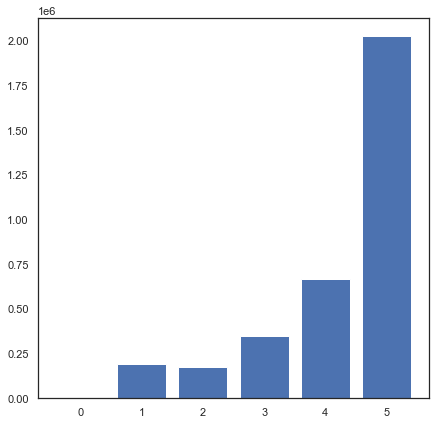

In [548]:
fig, ax = plt.subplots(figsize=(7,7))
rating_compare = ax.bar(uni, split_ratings)

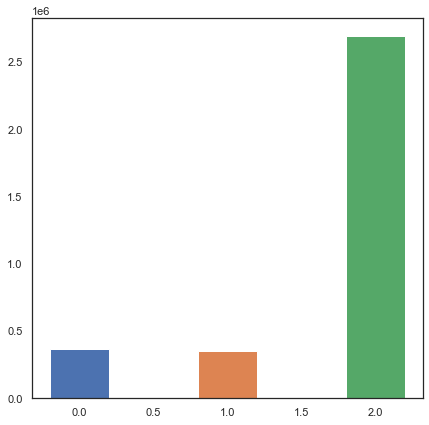

In [566]:
fig, ax = plt.subplots(figsize=(7,7))
categorized_ratings = np.array([sum(split_ratings[0:3]), split_ratings[3], sum(split_ratings[4:])])
for ind, bar in enumerate(categorized_ratings):
    ax.bar(ind, bar, width=0.4)

In [5]:
def categorize_arr(arr):
    arr = np.asarray(arr)
    
    # Conditions to categorize reviews
    positive = (arr == 5) | (arr == 4)
    neutral = (arr == 3)
    negative = (arr == 0) | (arr == 1) | (arr == 2)
    
    # Setting ratings to grouped values
    arr[positive] = 2
    arr[neutral] = 1
    arr[negative] = 0
    
    return arr

In [137]:
# Preprocessing data and training model
def train_model(estimators, file, validate=False, folds=5, test_size=0.2, start=None, end=None):
    """
    Training sentiment analysis model using
    given estimators and a file containing
    the dataset. Also performs rudimentary
    metrics such as scoring.
    
    Params
    ----
    
    estimators: list of tuples,
        Contains the estimators' string identifier and the
        estimator itself. Used to construct a pipeline.
    
    file: string.
        Path of the hdf5 file.
        
        NOTE: datasets must be in the order of "ratings"
        and "review_text".
    
    validate: bool, default=False.
        If true the model is trained through cross-validation 
        using the sklearn cross_validate function. 
        
        NOTE: Not suitable for very large datasets. 
        Performance implications are present.
    
    folds: int, default=5.
        Determines the number of fold/splits used
        in cross validation.
        
    test_size: float, default=0.2.
        Determines size of the test set when using the
        train_test_split function for model testing.
    
    Returns
    ----
    
    clf: sklearn.pipeline Pipeline
        Pipeline containing estimators passed from
        the estimators parameter. Mean to be saved
        to disk using joblib.
        
    metrics: list, shape(2)
         Contains the scoring metrics evaluated off
         of the test set. score method calculated
         from X_test and y_test, and balanced_accuracy_score
         method calculated from y_pred and y_test.
    
    score: dict
        Returned from cross_validate function.
    
    """
    
    with h5py.File(file, 'r') as f:
        keys = list(f.keys())
        ratings = f[keys[0]]
        corpus = f[keys[1]]
        clf = Pipeline(estimators)
        categorize = FunctionTransformer(categorize_arr)
        
        if validate is False:
            X_train, X_test, y_train, y_test = train_test_split(
                corpus[start: end].ravel(),
                categorize.transform(ratings[start: end].ravel()),
                test_size=test_size,
                random_state=42
            )
            with joblib.parallel_backend('threading', n_jobs=-1):
                joblib.Parallel(verbose=10)(joblib.delayed(clf.fit)(X_train, y_train) for i in range(1))
            y_pred = clf.predict(X_test)
            metrics = [clf.score(X_test, y_test), balanced_accuracy_score(y_test, y_pred)]
            return clf, metrics
        
        if validate is True:
            X = corpus[start: end].ravel()
            y = categorize.transform(ratings[start: end].ravel())
            score = cross_validate(clf, X, y, cv=folds, return_estimator=True, n_jobs=-1)
            return score

In [67]:
cnb_est = [('idf', TfidfVectorizer()), ('cnb', ComplementNB())]
#cnb = train_idf(ComplementNB(), './data/movies_reviews.hdf5')

0.8307517257963296


In [3]:
mnb_est = [('idf', TfidfVectorizer()), ('mnb', MultinomialNB())]
#mnb = train(MultinomialNB(), './data/movies_reviews.hdf5')

In [73]:
cnb.predict(['This is great my guy'])

array([2.])

In [74]:
# Storing models
joblib.dump(cnb, 'models/cnb.joblib')

['cnb.joblib']

In [76]:
joblib.dump(mnb, 'models/mnb.joblib')

['mnb.joblib']

In [80]:
test_cnb = joblib.load('models/cnb.joblib')

In [85]:
test_cnb.predict(['My guy this is great'])

array([2.])

In [116]:
# Testing cross val
with h5py.File('./data/fashion_reviews.hdf5', 'r') as f:
    ratings = f['fashion_ratings']
    corpus = f['fashion_review_text']
    pipe = make_pipeline(TfidfVectorizer(), ComplementNB())
    X_train, X_test, y_train, y_test = train_test_split(
        corpus[:].ravel(),
        categorize_arr(ratings),
        test_size=0.2
    )
    vec = pipe['tfidfvectorizer']
    X_train = vec.fit_transform(X_train)
    X_test = vec.transform(X_test)
    this_cnb = ComplementNB().fit(X_train, y_train.ravel())
    print(this_cnb.score(X_test, y_test))


0.9685534591194969


In [117]:
this_cnb.predict(vec.transform(['Horribly bad']))

array([1.])

In [128]:
# Testing cross val
with h5py.File('./data/fashion_reviews.hdf5', 'r') as f:
    ratings = f['fashion_ratings']
    corpus = f['fashion_review_text']
    clf = make_pipeline(TfidfVectorizer(), ComplementNB())
    X = corpus[:].ravel()
    y = categorize_arr(ratings).ravel()
    score = cross_validate(clf, X, y, cv=5, return_estimator=True)
    print(score)

{'fit_time': array([0.05877709, 0.05282879, 0.0542841 , 0.05296206, 0.05392694]), 'score_time': array([0.0124948 , 0.0142343 , 0.01321507, 0.01396799, 0.01395512]), 'estimator': (Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('complementnb', ComplementNB())]), Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('complementnb', ComplementNB())]), Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('complementnb', ComplementNB())]), Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('complementnb', ComplementNB())]), Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('complementnb', ComplementNB())])), 'test_score': array([0.90408805, 0.97637795, 0.97795276, 0.96377953, 0.97165354])}


In [155]:
n_grams = [('idf', TfidfVectorizer(ngram_range=(1, 2))), ('cnb', ComplementNB())]
cnb_ngrams, metrics = train_model(n_grams, './data/movies_reviews.hdf5', end=200_000)
#joblib.dump(cnb_ngrams, './models/cnb_bigrams.joblib')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   53.0s finished


In [156]:
cnb_ngrams, metrics

(Pipeline(steps=[('idf', TfidfVectorizer(ngram_range=(1, 2))),
                 ('cnb', ComplementNB())]),
 [0.83955, 0.3546432999718309])

In [162]:
cnb_ngrams.predict(['Bad'])

array([2.])

In [151]:
bow = [('idf', TfidfVectorizer()), ('cnb', ComplementNB())]
cnb_bow, bow_metrics = train_model(bow, './data/movies_reviews.hdf5', end=100_000)
#joblib.dump(cnb_ngrams, './models/cnb_bigrams.joblib')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.5s finished


In [152]:
cnb_bow, bow_metrics

(Pipeline(steps=[('idf', TfidfVectorizer()), ('cnb', ComplementNB())]),
 [0.84345, 0.3865749121431774])

In [154]:
cnb_bow.predict(['This is very terrible'])

array([0.])

In [13]:
# Testing cross val
with h5py.File('./data/movies_reviews.hdf5', 'r') as f:
    keys = list(f.keys())
    ratings = f[keys[0]]
    corpus = f[keys[1]]
    pipe = make_pipeline(TfidfVectorizer(), ComplementNB())
    curr_ind = 0
    for _ in range(50):
        end = curr_ind + 1000
        X_train = corpus[curr_ind: end].ravel()
        y_train = categorize_arr(ratings[curr_ind: end]).ravel()
        pipe.partial_fit(X_train, y_train)
        curr_ind = end

AttributeError: 'Pipeline' object has no attribute 'partial_fit'

In [80]:
def test_func():
    with h5py.File('./data/movies_reviews.hdf5', 'r') as f:
        keys = list(f.keys())
        ratings = f[keys[0]]
        corpus = f[keys[1]]
        clf = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), ComplementNB())
        X_train, X_test, y_train, y_test = train_test_split(
            corpus[:500_000].ravel(),
            categorize_arr(ratings[:500_000].ravel()),
            test_size=0.2,
            random_state=42
        )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(clf.score(X_test, y_test), balanced_accuracy_score(y_test, y_pred))
        return clf

In [81]:
clf = test_func()

0.82715 0.3618662771486533


In [42]:
n_grams = [('idf', TfidfVectorizer(ngram_range=(1, 2))), ('cnb', ComplementNB())]
%timeit train_model(n_grams, './data/movies_reviews.hdf5')

3.23 s ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [131]:
def test_parallel(estimators):
    with h5py.File('./data/movies_reviews.hdf5', 'r') as f:
        keys = list(f.keys())
        ratings = f[keys[0]]
        corpus = f[keys[1]]
        clf = Pipeline(estimators)
        categorize = FunctionTransformer(categorize_arr)
        X_train, X_test, y_train, y_test = train_test_split(
            corpus[:10_000].ravel(),
            categorize.transform(ratings[:10_000].ravel()),
            test_size=0.2,
            random_state=42
        )
        
        with joblib.parallel_backend('threading', n_jobs=-1):
            joblib.Parallel(verbose=10)(joblib.delayed(clf.fit)(X_train, y_train) for i in range(1))
        y_pred = clf.predict(X_test)
        print(clf.score(X_test, y_test))
        return clf

In [132]:
%timeit test_parallel(n_grams)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


0.8245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


0.8245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


0.8245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


0.8245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


0.8245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


0.8245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


0.8245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


0.8245
3.38 s ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [130]:
%timeit test_parallel(n_grams)

0.8245
0.8245
0.8245
0.8245
0.8245
0.8245
0.8245
0.8245
3.38 s ± 71.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [133]:
with joblib.parallel_backend('threading', n_jobs=-1):
    joblib.Parallel(verbose=10)(joblib.delayed(test_parallel)(n_grams) for i in range(1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished


0.8245


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished


In [171]:
with h5py.File('./data/movies_reviews.hdf5', 'r') as f:
    keys = list(f.keys())
    ratings = f[keys[0]]
    corpus = f[keys[1]]
    rate = categorize_arr(ratings[0:1_000_000]).ravel()
    corp = corpus[0: 1_000_000].ravel()

In [181]:
negatives = corp[rate == 0]
neutral = corp[rate == 1]
filtered_pos = corp[rate == 2][0:100_000]

In [183]:
y = np.concatenate([np.full(negatives.shape, 0.), np.full(neutral.shape, 1), np.full(filtered_pos.shape, 2)])

In [186]:
X = np.concatenate([negatives, neutral, filtered_pos])

In [194]:
def balance_test(X, y):
    balanced_clf = make_pipeline(TfidfVectorizer(), ComplementNB())
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42
    )
    
    with joblib.parallel_backend('threading', n_jobs=-1):
        joblib.Parallel(verbose=10)(joblib.delayed(clf.fit)(X_train, y_train) for i in range(1))
    y_pred = clf.predict(X_test)
    print(clf.score(X_test, y_test), balanced_accuracy_score(y_test, y_pred))
    return clf

In [195]:
bal_cnb = balance_test(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.7min finished


0.7264696871702352 0.7263743738048264


In [191]:
bal_cnb.predict(['I really hate these movies'])

array([0.])

In [193]:
joblib.dump(bal_cnb, './models/bal_cnb_bigrams.joblib')

['./models/bal_cnb_bigrams.joblib']

In [197]:
og_cnb = joblib.load('./models/cnb_bow.joblib')

In [198]:
og_cnb.score(X, y)

0.6330719007645541